In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from ipywidgets import interactive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Reading CSVs
~ ecs_updated (becomes ecs) - includes funding details for all 50 states + DC (needs to be merged on State)

~ enrollment_changes (becomes enrollments) - includes calculations for annual enrollment changes by NCES ID (filtered to local districts not affiliated with a supervisory union only and only includes columns needed for the loop or for merging, can be merged on State with ECS data or on NCES ID for other sources)

~ localdistricts (becomes localdistricts) - does not include enrollment change calculations, but does still include columns for locale, ZIP code, FTE count, pupil/teacher ratio, and year (can be merged on NCES ID or State depending on the need, shape aligns exactly to enrollment_changes)

~ enrollmentsdf (becomes fullnces) - primary dataframe until the loop; contains all columns and rows so it may ultimately prove to need more cleaning and restructuring than is helpful (can be merged by state or NCES ID)

In [ ]:
ecs = pd.read_csv("../data/ecs_updated.csv")
ecs.head(3)

In [ ]:
enrollments = pd.read_csv("../data/enrollment_changes.csv")
enrollments.head(3)

In [ ]:
localdistricts = pd.read_csv("../data/localdistricts.csv")
localdistricts.head(3)

In [ ]:
#unlikely to use, but here for reference as needed
fullnces = pd.read_csv("../data/enrollmentsdf.csv")
fullnces.head(3)

In [ ]:
netchangedist = enrollments.groupby(['State Name', 'Agency Name', 'NCES ID'])['Enrollment Change'].sum().reset_index()
netchangedist.head()

## Cleaning & Standardizing DataFrames

In [ ]:
ecs = ecs.drop("Unnamed: 0", axis=1)
ecs.head(2)

In [ ]:
ecs.rename(columns={'State':'State Name'}, inplace=True)
ecs.head(1)

In [ ]:
enrollments = enrollments.drop("Unnamed: 0", axis=1)
enrollments.head(2)

In [ ]:
netchangedist.rename(columns={'Enrollment Change':'Net Enrollment Change'}, inplace=True)
netchangedist.head(2)

## Merging DataFrames
Will also include dropping duplicate/unnecessary columns, standardizing column names, and reordering columns for efficiency.

In [ ]:
netenrollments = enrollments.merge(netchangedist, on='NCES ID', suffixes=('_nces', '_net'))
netenrollments.head(3)

In [ ]:
netenrollments.rename(columns={'Agency Name_nces':'Agency Name', 'State Name_nces':'State Name', 'Enrollment Change_nces':'Annual Enrollment Change', 'Enrollment Change_net':'Net Enrollment Change'}, inplace=True)
netenrollments.head(3)

In [ ]:
netenrollments = netenrollments.drop(['State Name_net', 'Agency Name_net'], axis=1)
netenrollments.head(3)

In [ ]:
enrollments.shape

In [ ]:
netchangedist.shape

In [ ]:
netenrollments.shape

In [ ]:
localdistricts.shape

In [ ]:
netandlocal = localdistricts.merge(netenrollments, on=['NCES ID', 'Year'], how='left', suffixes=('_loc', '_net'))
netandlocal.shape
#dataframes were the same shape - needed left merge rather than outer to avoid 8x duplicates

In [ ]:
netandlocal.head(3)

In [ ]:
netandlocal = netandlocal.drop(['Student Count_loc', 'Agency Name', 'District', 'State me'], axis=1)
netandlocal.head(3)

In [ ]:
netandlocal.rename(columns={'Agency me':'Agency Name', 'State me':'State Name', 'Student Count_net':'Student Count'}, inplace=True)
netandlocal.head(3)

In [ ]:
netandlocal.shape

In [ ]:
netfunding = netandlocal.merge(ecs, on='State Name', how='outer', suffixes=('_net', '_ecs'))
netfunding.shape

In [ ]:
netfunding.info()
#all rows should have a state name given the df shape and non-null count

In [ ]:
netfunding.head(2)

In [ ]:
#netfunding.to_csv("../data/netfunding.csv")

In [ ]:
#netandlocal.to_csv("../data/netandlocal2.csv")

In [ ]:
#netenrollments.to_csv("../data/netenrollments.csv")

## EDA & Additional DataFrames

In [30]:
data = pd.read_csv("../data/netfunding.csv")
data.shape

C:\Users\cbrown\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (21,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(104923, 58)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104923 entries, 0 to 104922
Data columns (total 58 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Unnamed: 0                                            104923 non-null  int64  
 1   Agency Name                                           104922 non-null  object 
 2   State Abbreviation                                    104922 non-null  object 
 3   NCES ID                                               104922 non-null  float64
 4   County                                                104898 non-null  object 
 5   School Count                                          104922 non-null  float64
 6   ZIP Code                                              104922 non-null  float64
 7   District Type                                         104922 non-null  float64
 8   Locale                                      

In [33]:
data.head(2)

,Unnamed: 0,Agency Name,State Abbreviation,NCES ID,County,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Year,State Name,Student Count,Enrollment Change,Net Enrollment Change,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source,Census Region,2020 Election Result,2020 Battleground State
0,0,ALABAMA YOUTH SERVICES,AL,100002.0,MONTGOMERY COUNTY,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,2013.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No
1,1,ALABAMA YOUTH SERVICES,AL,100002.0,JEFFERSON COUNTY,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,2014.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No


In [34]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head(1)

,Agency Name,State Abbreviation,NCES ID,County,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Year,State Name,Student Count,Enrollment Change,Net Enrollment Change,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source,Census Region,2020 Election Result,2020 Battleground State
0,ALABAMA YOUTH SERVICES,AL,100002.0,MONTGOMERY COUNTY,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,2013.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No


In [57]:
cols = list(data.columns.values)
cols

['Agency Name',
 'State Abbreviation',
 'NCES ID',
 'County',
 'School Count',
 'ZIP Code',
 'District Type',
 'Locale',
 'Start of Year Status',
 'Updated Status',
 'FTE Teachers',
 'Pupil/Teacher Ratio',
 'Total Staff',
 'Year',
 'State Name',
 'Student Count',
 'Enrollment Change',
 'Net Enrollment Change',
 'Primary Funding Model',
 'Model Name',
 'Notes',
 'Base Amount (Y/N)',
 'Base Amount',
 'Base Amount Legal Source',
 'Student Count Method',
 'Student Count Method Source',
 'Special Education Funding Mechanism',
 'Special Education Program Name',
 'Special Education Amount (Dollar amount or weight)',
 'Is there a Cap or Minimum threshold in place?',
 'Special Education Funding Description',
 'Special Education Funding Source',
 'English Learner Funding? (Y/N)',
 'English Learner Funding Mechanism',
 'English Learner Program Name',
 'English Learner Amount (Dollar amount or weight)',
 'ELL Amount Source',
 'At-Risk Funding for Low-Income Students (Y/N)',
 'Low-Income Students F

In [61]:
cols = ['Agency Name',
 'State Name',
 'State Abbreviation',
 'NCES ID',
 'County',
 'Student Count',
 'Year',
 'Enrollment Change',
 'Net Enrollment Change',
 'School Count',
 'ZIP Code',
 'District Type',
 'Locale',
 'Start of Year Status',
 'Updated Status',
 'FTE Teachers',
 'Pupil/Teacher Ratio',
 'Total Staff',
 'Census Region',
 '2020 Election Result',
 '2020 Battleground State',
 'Primary Funding Model',
 'Model Name',
 'Notes',
 'Base Amount (Y/N)',
 'Base Amount',
 'Base Amount Legal Source',
 'Student Count Method',
 'Student Count Method Source',
 'Special Education Funding Mechanism',
 'Special Education Program Name',
 'Special Education Amount (Dollar amount or weight)',
 'Is there a Cap or Minimum threshold in place?',
 'Special Education Funding Description',
 'Special Education Funding Source',
 'English Learner Funding? (Y/N)',
 'English Learner Funding Mechanism',
 'English Learner Program Name',
 'English Learner Amount (Dollar amount or weight)',
 'ELL Amount Source',
 'At-Risk Funding for Low-Income Students (Y/N)',
 'Low-Income Students Funding Mechanism',
 'Low-Income Students Program Name',
 'Low-Income Students Identifier',
 'Low-Income Students Amount (Dollar amount or weight)',
 'Low-Income Funding Source',
 'Gifted and Talented Funding? (Y/N)',
 'Gifted and Talented Funding Mechanism',
 'Gifted and Talented Program Name',
 'Gifted and Talented Amount (Dollar amount or weight)',
 'Gifted Funding Source',
 'Small Size or Isolated Adjustment? (Y/N)',
 'Small Size Funding Mechanism',
 'Small Size Program Name',
 'Small Size Amount (Dollar amount or weight)',
 'Small Size Identifier',
 'Small Size Identifier Source']

In [62]:
data = data[cols]
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.0,MONTGOMERY COUNTY,NaN,2013.0,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.0,JEFFERSON COUNTY,NaN,2014.0,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [68]:
data['NCES ID'] = data['NCES ID'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013.0,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014.0,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [69]:
data['Year'] = data['Year'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


C:\Users\cbrown\AppData\Local\Temp/ipykernel_27640/1524007300.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


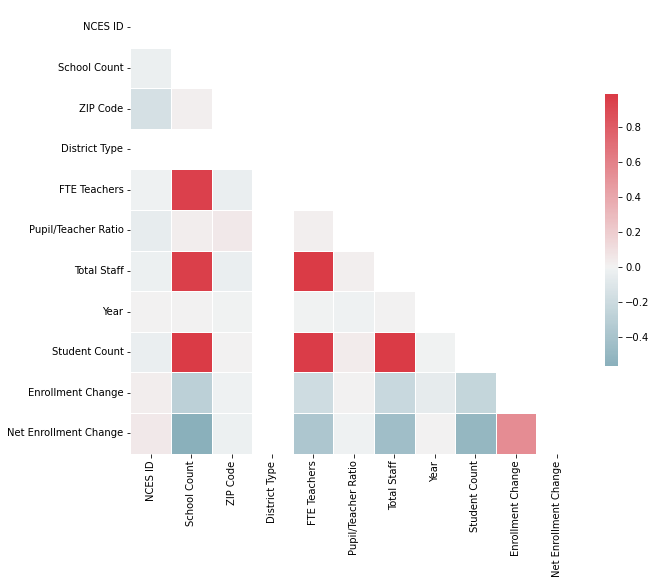

In [35]:
#looking for areas of strong correlation to dig into with deeper analysis
fig, ax = plt.subplots(figsize=(10, 10))

corr = data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [36]:
sbfdn = data.loc[data['Primary Funding Model'] == 'Student-based foundation']

In [37]:
rbased = data.loc[data['Primary Funding Model'] == 'Resource-based allocation']

In [38]:
hybrid = data.loc[data['Primary Funding Model'] == 'Hybrid']

In [39]:
gtbase = data.loc[data['Primary Funding Model'] == 'Guaranteed tax base']

In [40]:
baseamt = data.loc[data['Base Amount (Y/N)'] == 'Yes']

In [41]:
nbaseamt = data.loc[data['Base Amount (Y/N)'] == 'No']

In [42]:
northeast = data.loc[data['Census Region'] == 'Northeast']

In [43]:
midwest = data.loc[data['Census Region'] == 'Midwest']

In [44]:
south = data.loc[data['Census Region'] == 'South']

In [45]:
west = data.loc[data['Census Region'] == 'West']

In [46]:
republican = data.loc[data['2020 Election Result'] == 'Republican']

In [47]:
democrat = data.loc[data['2020 Election Result'] == 'Democrat']

In [48]:
batlgrnd = data.loc[data['2020 Battleground State'] == 'Yes']

In [49]:
nbatlgrnd = data.loc[data['2020 Battleground State'] == 'No']

In [54]:
#data.nlargest(25, 'Net Enrollment Change', keep='last')
#returns all 8 occurrences for each district even with the keep parameter - may need to pull list from other notebook and just create a subset df